# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [6]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [7]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [8]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [9]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [10]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [11]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal") 

#### Fonction quadratique

In [12]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

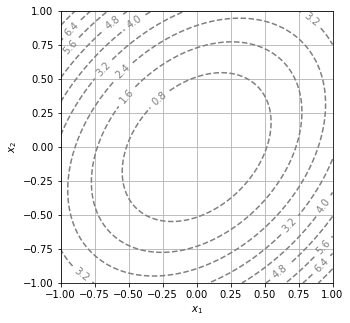

In [13]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [14]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

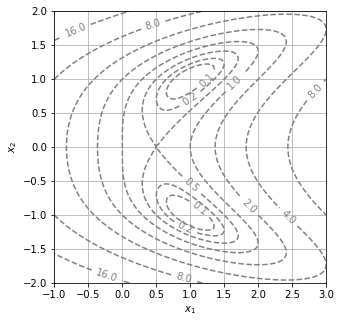

In [15]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [16]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

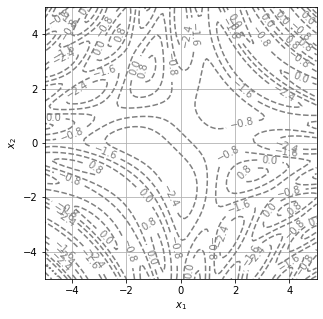

In [17]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [14]:
N = 100
# pas besoin d'une précision extrême, le tracé des courbes de niveau étant 
# précis a hauteur de l'épaisseur du trait de tracé, ici :
eps = 0.001 #semble suffisant

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
def Newton(F, x0, y0, eps=eps, N=N):
    J_F = J(F)
    for i in range(N):
        [x,y] = [x0, y0] - np.dot(np.linalg.inv(J_F(x0,y0)), F(x0,y0))
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [16]:
def F1(x,y):
    return np.array([f1(x,y)-0.8,x-y])

In [17]:
Newton(F1, 0.8, 0.8)

(0.4472135970019964, 0.4472135970019964)

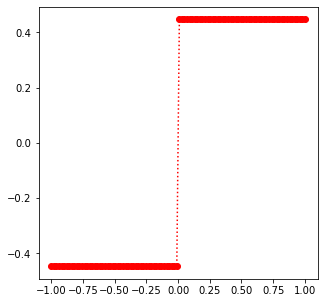

In [18]:
n = 100
X = np.linspace(-1,1,n)
Newton_vect = np.vectorize(Newton)
Y = Newton_vect(F1, X, X)
plt.plot(X,Y[0],'r:o')
plt.show()

In [19]:
def F1_2(x,y):
    return np.array([f1(x,y)-0.8,x-2*y])

In [20]:
Newton(F1_2, 0.8, 0.8)

(0.5393599759038217, 0.26967998795191084)

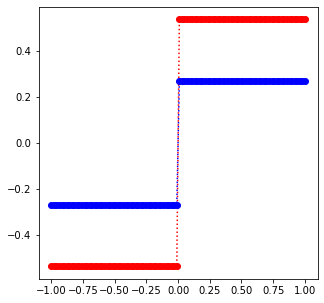

In [21]:
n = 100
X = np.linspace(-1,1,n)

#Newton_vect = vectorize(Newton)
#Y = Newton_vect(F1, X, X)
X1 = []
X2 = []
for i in range (0,n) :
    X1.append(Newton(F1_2, X[i], X[i])[0])
    X2.append(Newton(F1_2, X[i], X[i])[1])
plt.plot(X,X1,'r:o')
plt.plot(X,X2, 'b:o')
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [23]:
def level_curve0(f, x0, y0, c, delta=0.1, N=1000, eps=eps) : #on s'est permis de rajouter le paramètre c
    R = np.array([0.0,1.0,-1.0,0.0])
    R.resize((2,2)) #matrice de rotation de -pi/2
    grad_f = grad(f)
    T = np.zeros((2,N)) #tableau des points de la courbe de niveau
    T[0,0], T[1,0] = x0, y0
    x1, y1 = x0, y0     # x1, y1 sera l'invariant de boucle (le point considéré)
    for i in range (1,N):
        v_droite = np.dot(R,grad_f(x1,y1).T)         #vecteur orthogonal à droite du gradient de f en (x0,y0)
        u = v_droite/(v_droite[0]**2+v_droite[1]**2)**(0.5)      #on normalise v_droite
        # On pose une fonction de R2 dans R2 à partir de f garantissant la contrainte à droite à delta
        # en posant que le produit scalaire avec u de [x-x1, y-y1] vaut delta (lignes de champ orthogonales au gradient
        #donc au premier ordre le produit scalaire vaut la norme de [x-x1, y-y1]
        def f_R2(x,y):
            return np.array([f(x,y) - c, np.dot(np.array([x-x1, y-y1]),u.T) - delta])
        x1, y1 = Newton(f_R2, x1, y1, eps, 100)            #il faut garder delta>>eps pour des questions de cohérence
        T[0,i] , T[1,i] = x1, y1
    return T
            
    

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [31]:
def level_curve(f, x0, y0, c, delta=0.1, N=1000, eps=eps) : #on s'est permis de rajouter le paramètre c
    R = np.array([0.0,1.0,-1.0,0.0])
    R.resize((2,2)) #matrice de rotation de -pi/2
    grad_f = grad(f)
    X = [x0]
    Y = [y0]
    x1, y1 = x0, y0     # x1, y1 sera l'invariant de boucle (le point considéré)
    #N plafonne le nombre d'itérations
    for i in range (1,N):
        v_droite = np.dot(R,grad_f(x1,y1).T)         #vecteur orthogonal à droite du gradient de f en (x0,y0)
        u = v_droite/(v_droite[0]**2+v_droite[1]**2)**(0.5)      #on normalise v_droite
        # On pose une fonction de R2 dans R2 à partir de f garantissant la contrainte à droite à delta
        # en posant que le produit scalaire avec u de [x-x1, y-y1] vaut delta (lignes de champ orthogonales au gradient
        #donc au premier ordre le produit scalaire vaut la norme de [x-x1, y-y1]
        def f_R2(x,y):
            return np.array([f(x,y) - c, np.dot(np.array([x-x1, y-y1]),u.T) - delta])
        x1, y1 = Newton(f_R2, x1, y1, eps, 100)            #il faut garder delta>>eps pour des questions de cohérence
        X.append(x1)
        Y.append(y1)
        if ((x1-x0)**2+(y1-y0)**2)**0.5 < delta - eps: #on fait des pas de l'ordre de delta, après un tour, on a de grandes chances de se trouver à moins de delta - eps du point de départ
            return np.array([X,Y])
    return np.array([X,Y])
            
    

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

In [25]:
def plt_level_curve0(f, x0, y0, c, delta=0.1, N=1000, eps=eps):
    X, Y = level_curve0(f, x0, y0, c, delta, N, eps)
    plt.plot(X,Y, 'r:o')
    plt.show()

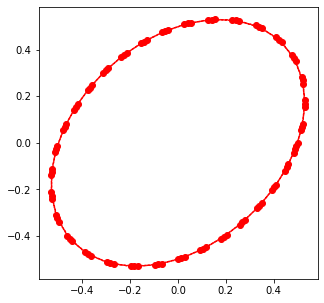

In [26]:
plt_level_curve0(f1,0.5,0.0,0.75,0.1,100,0.001)

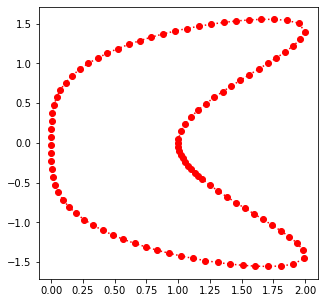

In [27]:
plt_level_curve0(f2,1.,0.0,1.0,0.1,100,0.001)

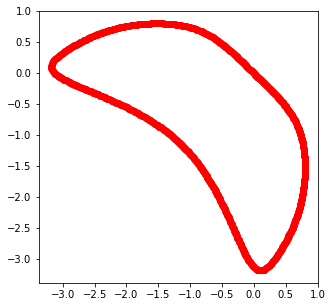

In [28]:
plt_level_curve0(f3,0.0,0.0,-2.0,0.1,1000,0.001)

In [32]:
def plt_level_curve(f, x0, y0, c, delta=0.1, N=1000, eps=eps):
    X, Y = level_curve(f, x0, y0, c, delta, N, eps)
    plt.plot(X,Y, 'r:o')
    plt.show()

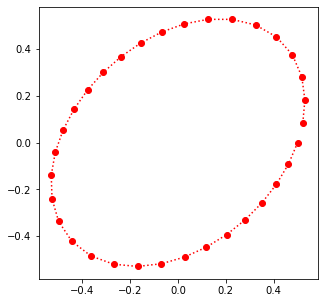

In [33]:
plt_level_curve(f1,0.5,0.0,0.75,0.1,100,0.001)

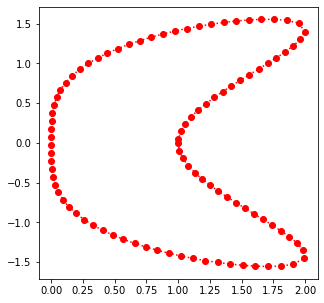

In [34]:
plt_level_curve(f2,1.,0.0,1.0,0.1,100,0.001)

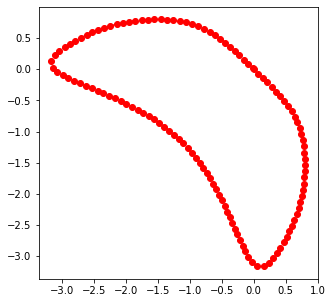

In [35]:
plt_level_curve(f3,0.0,0.0,-2.0,0.1,1000,0.001)

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

In [2]:
def area_squares(f,c,h,l): #le paramètre l permet de déterminer la taille du grand carré centré en 0 de côté 2*l sur lequel on compte les petits carrés
    A_h = 0
    a = h**2
    m = int(2*l/h)
    for i in range(0,m):
        for j in range (0,m):
            if f(-l+(i+0.5)*h, -l+(j+0.5)*h)<=c:
                A_h = A_h + h**2
    return A_h


In [37]:
def distance(x,y):
    return (x**2+y**2)**0.5

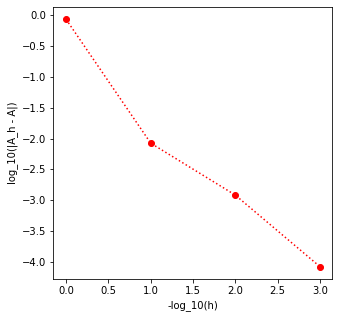

In [38]:
p = 4
X = []
Y = []
for i in range (0,p):
    X.append(i)
    Y.append(np.log10(np.abs(area_squares(distance, 1, 10**(-i),1.05)-np.pi)))
plt.plot(X,Y,'r:o')
plt.xlabel('-log_10(h)')
plt.ylabel('log_10(|A_h - A|)')
plt.show()

In [39]:
#pente de l'ordre de -1 donc convergence de l'ordre 10**(-1.15*(-log10(h))) i.e. en h

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [40]:
# Pour avoir un encadrement exact de l'aire, on peut tester l'appartenance des 4 coins de chaque petit carré au disque unité, par
#convexité du carré et de la boule l'entièreté du petit carré est alors dans la boule On peut alors minorer l'aire.
#Pour la majorer, on compte chaque carré dont un des coins appartient à la boule. On obtient alors un recouvrement dont l'aire
#est supérieure à celle de la boule.
def encadrement(f, c, eps = 0.01):
    diff = 1    #choix arbitraire diff>eps au départ
    h = eps     #choix susceptible de marcher
    while diff > eps :  
        inf = 0
        sup = 0
        a = h**2
        m = int(2.1/h)
        for i in range(0,m):
            for j in range (0,m):
                u = (f(-1.05+i*h, -1.05+j*h)<=c) + (f(-1.05+i*h, -1.05+(j+1)*h)<=c) + (f(-1.05+(i+1)*h, -1.05+j*h)<=c) + (f(-1.05+(i+1)*h, -1.05+(j+1)*h)<=c)
                if u == 4:
                    inf = inf + a
                if u > 0:
                    sup = sup + a
        diff = sup - inf
        h = h*0.2
    return (inf, sup)


In [41]:
encadrement(distance, 1, 0.01)


(3.139968638997908, 3.1431686389962237)

## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [42]:

def trianglearea(a,b,c):
    u = np.array([b[0]-a[0], b[1]-a[1]])
    v = np.array([c[0]-b[0], c[1]-b[1]])
    base = (u[0]**2+u[1]**2)**0.5
    hauteur = ( (v[0]**2+v[1]**2) - np.dot(u/base,v.T)**2 )**0.5
    return base*hauteur/2

def area_triangle(Front, p) :
    B_N = 0
    for i in range (0, Front.shape[0] - 1) :
        B_N = B_N + trianglearea(p, Front[i], Front[i+1])
    B_N = B_N + trianglearea(p, Front[-1], Front[0])
    return B_N


In [43]:
N = 100000
p = (0.0, 0.0)
Front = np.zeros((N,2))
for k in range (0,N) :
    Front[k] = [np.cos(2*np.pi*k/N),np.sin(2*np.pi*k/N)]

area_triangle(Front, p) 


3.1415926515177404

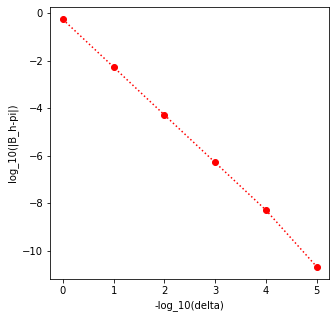

In [44]:
def Front(N):
    Front = np.zeros((N,2))
    for k in range (0,N) :
        Front[k] = [np.cos(2*np.pi*k/N),np.sin(2*np.pi*k/N)]
    return Front

# delta = 2*np.pi/N écart entre points consécutifs de la frontière ainsi N = int(2*np.pi/delta)

p = (0.0,0.0)

X = []
Y = []
for i in range (0,6):
    X.append(i)
    Y.append(np.log10(abs(area_triangle(Front(int(2*np.pi/10**(-i))),p)-np.pi)))  #10**(-i) correspond écart points consécutifs
plt.plot(X,Y,'r:o')
plt.xlabel('-log_10(delta)')
plt.ylabel('log_10(|B_h-pi|)')
plt.show()


In [45]:
# pente de l'ordre de -2 donc décroissance de l'erreur de l'ordre de delta**2

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [46]:
def trianglearea_alg(a,b,c): #Calcule l'aire algébrique d'un triangle dépendant de l'ordre de ses sommets (+ si a,b,c sens trigo, - sinon)
    u = np.array([b[0] - a[0], b[1] - a[1]])
    v = np.array([c[0] - a[0], c[1] - a[1]])
    #On fait le produit vectoriel entre u et v selon la composante z
    return (u[0]*v[1]-u[1]*v[0])/2

def area_triangle_alg(Front, p) :
    B_N = 0
    for i in range (0, Front.shape[0] - 1) :
        B_N = B_N + trianglearea_alg(p, Front[i], Front[i+1])
    B_N = B_N + trianglearea_alg(p, Front[-1], Front[0])
    return abs(B_N)    # en fait le signe de B_N dépend du sens de parcours de la frontière (+ sens trigo, - sinon)


In [47]:
N = 100000
p = (2.0, 4.3)
Front = np.zeros((N,2))
for k in range (0,N) :
    Front[k] = [np.cos(2*np.pi*k/N),np.sin(2*np.pi*k/N)]

area_triangle_alg(Front, p) 


3.1415926515227204

In [48]:
#Si on parcourt la frontière dans le sens trigo, l'ensemble E_1 des triangles dont l'intersection avec K est non vide ont
#une aire comptée positivement. Soit A_1 l'ensemble des points contenus dans ces triangles
#L'ensemble E_2 des triangles d'intersection vide avec K ont une aire comptée négativement. A_2 ensemble des points dans ces triangles
# K est inclus dans A_1 et A_2 est exactement A_1\K
# D'où le résultat souhaité lorsqu'on somme l'aire de A_1 avec -(l'aire de A_2)


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [49]:
def Front(N):
    Front = np.zeros((N,2))
    for k in range (0,N) :
        Front[k] = [np.cos(2*np.pi*k/N),np.sin(2*np.pi*k/N)]
    return Front

N=10000
D1 = Front(N)
D2 = 0.5*Front(N) + np.array([[4.0,6.4] for i in range (0,N)])
p = (23.0,1.0)
A = area_triangle_alg(D1,p) + area_triangle_alg(D2,p)
#résultat attendu proche de 1.25*np.pi
print(A)
print(1.25*np.pi)

3.9269905586018687
3.9269908169872414


In [50]:
# Dans le cas où K n'est pas convexe c'est la même chose sauf qu'on peut compter le nombre de fois où 
# la frontière coupe l'intérieur de chaque triangle. On peut appeler ce nombre le degré du triangle.
# Lorsque le degré est pair on compte le triangle négativement, lorsqu'il est impair, on le compte positivement.

#Si on change de point de vue
#l'ensemble des triangles constitue un recouvrement de K lequel on compte les parties contenues dans un nombre impair de
#de triangles et ignore les parties contenues dans un nombre pair de triangles 

#Si on considère les triangles T_1,..., T_n
# formule du crible en soit appliquée à K inter T_1,....., K inter T_n 

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [51]:
def area_triangles(x,y):
    N = x.shape[0]
    Front = np.zeros((N,2))
    for i in range (0,N):
        Front[i,0], Front[i,1] = x[i], y[i]
    B_N = 0
    for i in range (0, Front.shape[0] - 1) :
        B_N = B_N + trianglearea_alg(p, Front[i], Front[i+1])
    B_N = B_N + trianglearea_alg(p, Front[-1], Front[0])
    return abs(B_N)

In [52]:
area_triangles(level_curve(f1,0.5,0.0,0.75,0.1,100,0.001)[0], level_curve(f1,0.5,0.0,0.75,0.1,100,0.001)[1])

0.8277557485469762

In [24]:
area_squares(f1,0.75,0.01,0.5)

0.8059999999999276

In [53]:
area_triangles(level_curve(f2,1.,0.0,1.0,0.1,100,0.001)[0], level_curve(f2,1.,0.0,1.0,0.1,100,0.001)[1])

3.6666545801214525

In [25]:
area_squares(f2,1.0,0.01,2.1)

3.6720000000033246

In [54]:
area_triangles(level_curve(f3,0.0,0.0,-2.0,0.1,1000,0.001)[0],level_curve(f3,0.0,0.0,-2.0,0.1,1000,0.001)[1])

7.0527707051432

In [28]:
area_squares(f3,-2.0,0.01,3.2)

9.596099999990974

In [29]:
#Ici ca ne marche pas car on calcule le nombre de carrés dont l'image du centre est inférieur à c=-2.0 mais rien ne 
#dit que cela correspond aux carrés à l'intérieur de la courbe 
#Par ailleurs, le cadre sur lequel on étudie l'appartenance à l'espace délimité par la courbe de niveau est trop grand
#ce qui augmente les chances de compter des carrés à l'extérieur dont l'image du centre est inférieure à c=-2.0


In [30]:
#Méthode des carrés 
# plus lente (complexité en 1/h**2) et beaucoup de carrés explorés inutilement
# moins précise (convergence de la précision en h) 
# mais dépend pas trop de la qualité de la frontière (plus du choix du côté h des carrés)
# Possibilité d'encadrement de la valeur cherchée

# méthode des triangles 
#plus rapide ( complexité en 1/delta) 
# plus précise (convergence de la précision en delta**2)
# mais précision dépend fortement d'une connaissance précise de la frontière.
# Pas de possibilité d'encadrement

